In [1]:
import pandas as pd
import glob
import re

> Load all the data into one dataframe

In [2]:
# Using glob  & regex to get all the files appropriate files in the directory
egrid_files = glob.glob("../data/rmr_62/egrid_data/e[Gg][Rr][Ii][Dd]*.xls*")

In [3]:
# Reading the egrid files into a pandas dataframe, only keep the tab we need
egrid_df = pd.DataFrame()
for file in egrid_files:
    match = re.search(r"\d{4}", file)
    year = match.group()

    df = pd.read_excel(file, sheet_name=f"PLNT{year[-2]}{year[-1]}", skiprows=1)
    print("Getting Electricity Grid Data From: ", year)
    df["Year"] = year

    # Rename the columns to match the other dataframes
    df = df.rename(columns={"PLPRIMFL": "PLPRMFL"})

    egrid_df = pd.concat([egrid_df, df])

del df  # Clean up

# Create a new DataFrame with the additional column
egrid_df = egrid_df.assign(AverageCap=egrid_df["NAMEPCAP"] * egrid_df["CAPFAC"])

Getting Electricity Grid Data From:  2012
Getting Electricity Grid Data From:  2021
Getting Electricity Grid Data From:  2019
Getting Electricity Grid Data From:  2020
Getting Electricity Grid Data From:  2000
Getting Electricity Grid Data From:  2007
Getting Electricity Grid Data From:  2010
Getting Electricity Grid Data From:  1998
Getting Electricity Grid Data From:  2018
Getting Electricity Grid Data From:  2009
Getting Electricity Grid Data From:  2004
Getting Electricity Grid Data From:  2016
Getting Electricity Grid Data From:  2014
Getting Electricity Grid Data From:  1999
Getting Electricity Grid Data From:  2005


## Column name descriptions

| Column    | Description |
|-----------|-------------|
| PNAME     | Plan Name |
| PLPRMFL   | Primary Fuel |
| CAPFAC    | Capacity Facoty |
| NAMEPCAP  | Nameplate Capacity |
| PLNGENAN  | Plant annual net genration (MWh) |
| PLNOXAN   | Plant annual Nox Emission (tonnes) |
| PLSO2AN   | Plant annual So2 Emission (tonnes) |
| PLCO2AN   | Plant annual Co2 Emission (tonnes) |
| Year      | Data for Year |
| TotEm     | Total aanual plant emissions (tonnes) |

In [4]:
# Keep only the columns we need
egrid_df = egrid_df[
    [
        "PNAME",
        "PLPRMFL",
        "PLNGENAN",
        "PLNOXAN",
        "PLSO2AN",
        "PLCO2AN",
        "Year",
    ]
]

# Calculatin total emissions
c = "TotEm"
c2 = "PLNOXAN"
egrid_df.loc[:, c] = egrid_df[c2] + egrid_df["PLSO2AN"] + egrid_df["PLCO2AN"]

In [5]:
# Keep only the renewable fuels
renewable_fuels = ["WAT", "WND", "SUN", "GEO", "HYD", "BIO", "LFG", "OBG", "BG"]
egrid_df_renewable = egrid_df[egrid_df["PLPRMFL"].isin(renewable_fuels)]

# Group by year and sum the emissions for the renewable fuels
cols = ["PLNGENAN", "PLNOXAN", "PLSO2AN", "PLCO2AN", "TotEm"]
egrid_df_renewable_by_year = egrid_df_renewable.groupby("Year")[cols].sum()

# Group by year and sum the emissions for all fuels
egrid_by_year = egrid_df.groupby("Year")[cols].sum()

In [7]:
# Load the emissions data
# U.S. Greenhouse Gas Emissions by Gas, 1990–2021
# Source: EPA's Climate Change Indicators in the United States
# www.epa.gov/climate-indicators

emissions_df = pd.read_csv("../data/rmr_62/emissions_data/emissions_epa.csv")

# Calculate the total economic_emissions
emissions_df = emissions_df.assign(
    total_emissions=pd.to_numeric(emissions_df.iloc[:, 1].str.replace(",", ""))
    + pd.to_numeric(emissions_df.iloc[:, 2])
    + pd.to_numeric(emissions_df.iloc[:, 3])
    + pd.to_numeric(emissions_df.iloc[:, 4])
)

# convert the total emissions to metric tons
emissions_df["total_emissions"] = emissions_df["total_emissions"] * 10**6

egrid_by_year = egrid_by_year.reset_index()
egrid_by_year["Year"] = pd.to_numeric(egrid_by_year["Year"])
final_df_by_year = egrid_by_year.merge(emissions_df, on="Year", how="left")

<Figure size 1500x1000 with 0 Axes>

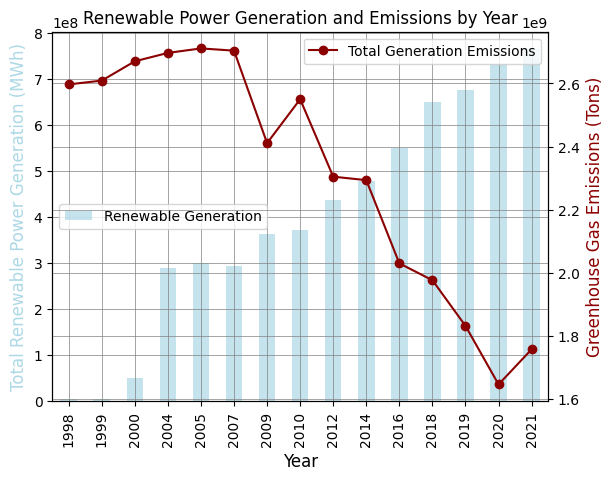

In [13]:
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(15, 10))

# Plot total renewable generation by year as a bar plot
ax = egrid_df_renewable_by_year.plot(
    kind="bar", y="PLNGENAN", color="lightblue", alpha=0.7
)


# Plot total emissions by year as a line plot on a secondary y-axis
ax2 = egrid_by_year.plot(
    kind="line", y="TotEm", secondary_y=True, ax=ax, color="darkred", marker="o"
)

# Add gridlines
ax.grid(True, which="both", color="gray", linewidth=0.5)
ax2.grid(True, which="both", color="gray", linewidth=0.5)

# Add a title and labels
plt.title("Renewable Power Generation and Emissions by Year", fontsize=12)
ax.set_ylabel("Total Renewable Power Generation (MWh)", fontsize=12, color="lightblue")
ax2.set_ylabel("Greenhouse Gas Emissions (Tons)", fontsize=12, color="darkred")
ax.set_xlabel("Year", fontsize=12)

# Add a legend
ax.legend(["Renewable Generation"], loc="center left")
ax2.legend(["Total Generation Emissions"], loc="upper right")


# set x-axis labels
ax.set_xticks(range(len(egrid_df_renewable_by_year)))
ax.set_xticklabels(egrid_df_renewable_by_year.index, rotation=90)

# Show the plot
plt.show()

<Figure size 1500x1000 with 0 Axes>

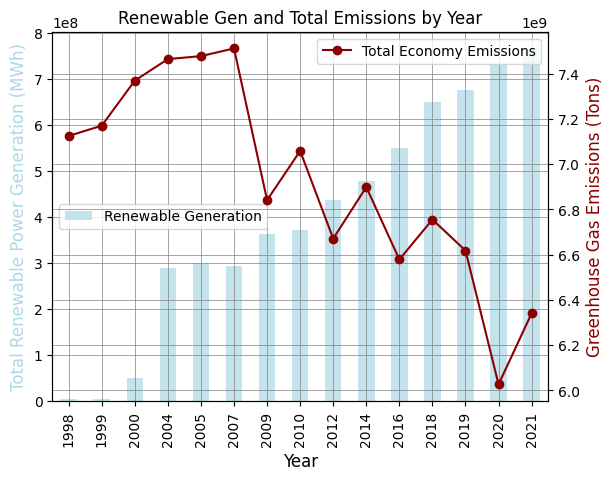

In [18]:
# Create a larger figure
plt.figure(figsize=(15, 10))

# Plot total renewable generation by year as a bar plot
ax = egrid_df_renewable_by_year.plot(
    kind="bar", y="PLNGENAN", color="lightblue", alpha=0.7
)


# Plot total emissions by year as a line plot on a secondary y-axis
ax2 = final_df_by_year.plot(
    kind="line",
    y="total_emissions",
    secondary_y=True,
    ax=ax,
    color="darkred",
    marker="o",
)

# Add gridlines
ax.grid(True, which="both", color="gray", linewidth=0.5)
ax2.grid(True, which="both", color="gray", linewidth=0.5)

# Add a title and labels
plt.title("Renewable Gen and Total Emissions by Year", fontsize=12)
ax.set_ylabel("Total Renewable Power Generation (MWh)", fontsize=12, color="lightblue")
ax2.set_ylabel("Greenhouse Gas Emissions (Tons)", fontsize=12, color="darkred")
ax.set_xlabel("Year", fontsize=12)

# Add a legend
ax.legend(["Renewable Generation"], loc="center left")
ax2.legend(["Total Economy Emissions"], loc="upper right")


# set x-axis labels
ax.set_xticks(range(len(egrid_df_renewable_by_year)))
ax.set_xticklabels(egrid_df_renewable_by_year.index, rotation=90)

# Show the plot
plt.show()

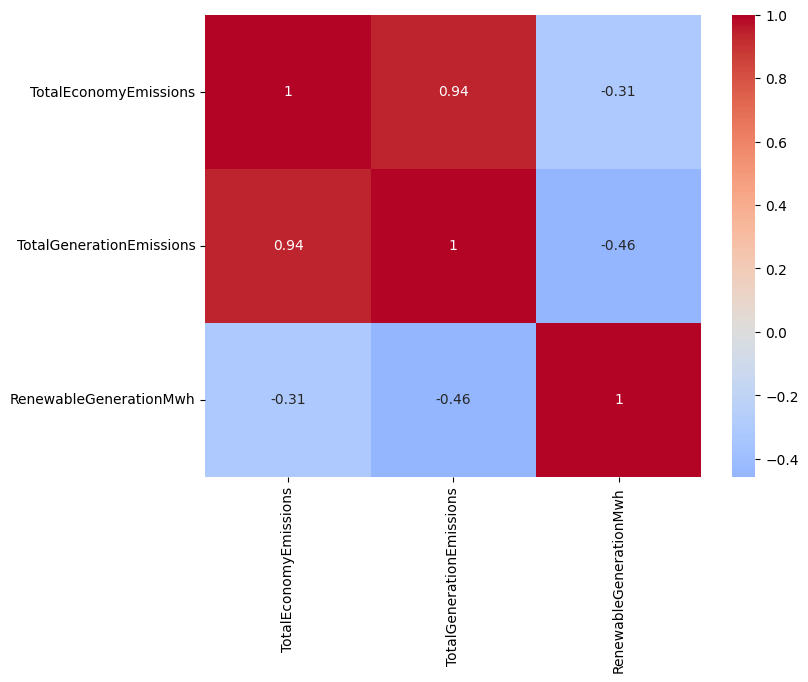

In [23]:
# corrleation between renewable generation, toal emissions and economy emissions
import seaborn as sns

final_df_by_year = final_df_by_year.rename(
    columns={
        "total_emissions": "TotalEconomyEmissions",
        "TotEm": "TotalGenerationEmissions",
        "PLNGENAN": "RenewableGenerationMwh",
    }
)
corr = final_df_by_year[
    ["TotalEconomyEmissions", "TotalGenerationEmissions", "RenewableGenerationMwh"]
].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)

# Show the plot
plt.show()

### Report on Correlation Analysis of Emissions and Renewable Energy Generation
## Introduction
This report presents the results of a correlation analysis conducted on data 
related to emissions and renewable energy generation in the United States. The 
aim of the analysis was to understand the relationships between these variables.

## Methodology
The analysis was conducted using the Pearson correlation coefficient, a measure 
of the linear relationship between variables. The variables considered in this 
analysis were:

>Total emissions from the whole economy
>Emissions from power generation
>Renewable power generation

## Results
The correlation analysis revealed the following key findings:

>There is a negative correlation between renewable energy generation and 
emissions from power generation. This suggests that as renewable energy 
generation increases, emissions from power generation decrease. This is an 
expected result, as renewable energy sources such as wind, solar, and hydro do 
not produce emissions when generating electricity.

>There is a positive correlation between emissions from the whole economy and 
emissions from power generation. This indicates that as emissions from the whole
economy increase, emissions from power generation also increase. This suggests
that power generation is a significant contributor to total emissions in the 
economy.

>The correlation between emissions from power generation and renewable energy 
generation is stronger than the correlation between total emissions from the 
economy and renewable energy generation. This suggests a more direct 
relationship between renewable energy generation and emissions from power 
generation.

## Visual Analysis
The heatmap visualization of the correlation matrix clearly illustrates these 
relationships. The negative correlation between renewable energy generation 
and emissions is visually evident, with a clear decrease in emissions as 
renewable capacity increases. This trend is observed for both power 
generation emissions and total economy emissions, reinforcing the impact 
of renewable energy sources on reducing emissions.

## Conclusion
The results of this analysis suggest a clear relationship between renewable 
energy generation and emissions, particularly emissions from power generation.
As renewable energy generation increases, emissions from power generation 
decrease. This underscores the importance of renewable energy in reducing 
emissions and combating climate change. The visual analysis further 
emphasizes these findings, providing a clear and intuitive representation
of the relationships between these variables. Further research could 
investigate the impact of specific types of renewable energy on 
emissions and identify the most effective strategies for increasing 
renewable energy generation.